In [1]:
from tempfile import TemporaryDirectory
from subprocess import run

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

from openmm import app, unit, LangevinMiddleIntegrator, LocalEnergyMinimizer

from molclub.conf_tools import etkdg, crest
from molclub.compute import gfnff, gfnxtb, orca_dft
from molclub import visualize

orca_dir = '/Users/ozone/bin/_orca_5_0_3'

In [2]:
def get_atom_counter(mol):
    symbols = set([atom.GetSymbol() for atom in mol.GetAtoms()])
    atom_counter = {symbol: 1 for symbol in symbols}
    return atom_counter

def set_pdb_info(mol, name):
    mol.SetProp('_Name', name)
    atom_counter = get_atom_counter(mol)
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        counter = atom_counter[symbol]
        atom_counter[symbol] += 1
        info = Chem.AtomPDBResidueInfo()
        info.SetName(f'{symbol}{counter}')
        info.SetIsHeteroAtom(True)
        info.SetResidueName(name)
        info.SetResidueNumber(1)
        atom.SetPDBResidueInfo(info)

def prep_mol_for_pdb(smi, name):
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)

    mols = etkdg.generate_conformers(mol)
    mols = [gfnff.opt(mol)[0] for mol in mols]
    energies = [gfnxtb.sp(mol) for mol in mols]
    mols, energies = zip(*(sorted(zip(mols, energies), key=lambda x: x[1])))
    mol = mols[0]

    set_pdb_info(mol, name)
    return mol

class AtomType():
    __slots__ = ['symbol', 'neighbors']

    def __init__(self, atom):
        self.symbol = atom.GetSymbol()
        self.neighbors = {}
        mol = atom.GetOwningMol()
        atom_idx = atom.GetIdx()
        rank = 1
        traversed_idxs = {atom_idx}
        neighbors = {neighbor.GetIdx() for neighbor in atom.GetNeighbors()}
        while len(neighbors) != 0:
            traversed_idxs.update(neighbors)
            self.neighbors[rank] = sorted([mol.GetAtomWithIdx(neighbor).GetSymbol() for neighbor in neighbors])
            rank += 1
            new_neighbors = set()
            for neighbor in neighbors:
                next_neighbors = mol.GetAtomWithIdx(neighbor).GetNeighbors()
                next_neighbors = [neighbor.GetIdx() for neighbor in next_neighbors]
                next_neighbors = set([neighbor for neighbor in next_neighbors if neighbor not in traversed_idxs])
                new_neighbors.update(next_neighbors)
            neighbors = new_neighbors

    def match(self, other, rank):
        if self.symbol != other.symbol:
            return False
        min_rank = min(max(self.neighbors.keys()), max(other.neighbors.keys()))
        min_rank = min(min_rank, rank)
        ranks = range(1, min_rank)
        for rank in ranks:
            if self.neighbors[rank] != other.neighbors[rank]:
                return False
        return True

    def __repr__(self):
        output = self.symbol + ': '
        output += str(self.neighbors)
        return output

def get_unique_atom_types(atom_types):
    unique_atom_types = []
    for atom_type in atom_types:
        matches = False
        for unique_atom_type in unique_atom_types:
            if atom_type.match(unique_atom_type, 1000):
                matches = True

        if not matches:
            unique_atom_types.append(atom_type)

    return unique_atom_types

def get_atom_param(atom_type, df):
    df = df.loc[df.symbol == atom_type.symbol]
    if len(df) == 0:
        raise ValueError(f'no parameters available for {atom_type.symbol}')

    for i, col in enumerate([col for col in df.columns if 'neighbor' in col]):
        try:
            df_tmp = df.loc[df[col].apply(lambda x: x == atom_type.neighbors[i+1])]
        except:
            break
        if len(df_tmp) == 0:
            break
        df = df_tmp

    df['n_none'] = df.apply(lambda x: len([value for value in x if value is None]), axis=1)
    df = df.sort_values(['n_none'], ascending=False)
    row = df.iloc[0]
    return {
        'element': row.symbol,
        'name': row['name'],
        'class': row['class'],
        'mass': row['mass'],
    }

def get_atom_params(mol, df_atoms):
    atom_types = [AtomType(atom) for atom in mol.GetAtoms()]
    unique_atom_types = get_unique_atom_types(atom_types)

    atom_params = [get_atom_param(atom_type, df_atoms) for atom_type in atom_types]
    unique_atom_params = [get_atom_param(atom_type, df_atoms) for atom_type in unique_atom_types]

    return atom_params, unique_atom_params

def get_bond_param(atom_types, df):
    rev_atom_types = atom_types.copy()
    rev_atom_types.reverse()
    return df.loc[df.atoms.apply(lambda x: x == atom_types or x == rev_atom_types)].iloc[0]

def get_angle_param(atom_types, df):
    rev_atom_types = list(reversed(atom_types))
    return df.loc[df.atoms.apply(lambda x: x == atom_types or x == rev_atom_types)].iloc[0]

def get_unique_angles(mol, atom_params):
    angles = []
    for idxs in mol.GetSubstructMatches(Chem.MolFromSmarts('***')):
        atom_types = [atom_params[idx]['name'] for idx in idxs]
        angles.append(atom_types)

    unique_angles = []
    for angle in angles:
        if angle not in unique_angles:
            unique_angles.append(angle)

    return unique_angles

def get_energy(simulation):
    state = simulation.context.getState(getEnergy=True)
    return state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)

def set_positions(simulation, positions):
    q_positions = unit.Quantity(np.reshape(positions, (len(positions)//3, 3)), unit.nanometers)
    simulation.context.setPositions(q_positions)
    return simulation

def get_pdb_atom_names(mol):
    pdb_atoms = [line for line in Chem.MolToPDBBlock(mol).split('\n') if line.startswith('HETATM')]
    return [line.split()[2] for line in pdb_atoms]

def get_ff_xml_block(mol, df_atoms, df_bonds, df_angles):
    atom_names = get_pdb_atom_names(mol)
    atom_params, unique_atom_params = get_atom_params(mol, df_atoms)

    ff_xml_block = """<ForceField>
    <AtomTypes>
    """
    for atom_param in unique_atom_params:
        ff_xml_block += f'    <Type name="{atom_param["name"]}" class="{atom_param["class"]}" element="{atom_param["element"]}" mass="{atom_param["mass"]}"/>\n'

    ff_xml_block += f'  </AtomTypes>\n\n  <Residues>\n    <Residue name="{mol.GetProp("_Name")}">\n'

    for atom_name, atom_param in zip(atom_names, atom_params):
        ff_xml_block += f'      <Atom name="{atom_name}" type="{atom_param["name"]}"/>\n'

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        ff_xml_block += f'      <Bond atomName1="{atom_names[i]}" atomName2="{atom_names[j]}"/>\n'

    ff_xml_block += '    </Residue>\n  </Residues>\n\n  <CustomBondForce energy="k1 * (r - r0)^2 + k2 * (r - r0)^3">\n    <PerBondParameter name="k1"/>\n    <PerBondParameter name="k2"/>\n    <PerBondParameter name="r0"/>\n'

    bond_xml_lines = set()
    for bond in mol.GetBonds():
        type_1 = atom_params[bond.GetBeginAtomIdx()]['name']
        type_2 = atom_params[bond.GetEndAtomIdx()]['name']
        atom_types = sorted([type_1, type_2])
        bond_param = get_bond_param(atom_types, df_bonds)
        bond_xml_lines.add(f'    <Bond type1="{type_1}" type2="{type_2}" k1="{bond_param["k1"]}" k2="{bond_param["k2"]}" r0="{bond_param["r0"]}"/>\n')

    for bond_xml_line in bond_xml_lines:
        ff_xml_block += bond_xml_line

    ff_xml_block += '  </CustomBondForce>\n\n  <CustomAngleForce energy="k1 * (theta - theta0)^2 + k2 * (theta - theta0)^3">\n    <PerAngleParameter name="k1"/>\n    <PerAngleParameter name="k2"/>\n    <PerAngleParameter name="theta0"/>\n'

    angle_xml_lines = set()
    for atom_types in get_unique_angles(mol, atom_params):
        outer = sorted([atom_types[0], atom_types[2]])
        atom_types = [outer[0], atom_types[1], outer[1]]
        angle_param = get_angle_param(atom_types, df_angles)
        angle_xml_lines.add(f'    <Angle type1="{atom_types[0]}" type2="{atom_types[1]}" type3="{atom_types[2]}" k1="{angle_param["k1"]}" k2="{angle_param["k2"]}" theta0="{angle_param["theta0"]}"/>\n')

    for angle_xml_line in angle_xml_lines:
        ff_xml_block += angle_xml_line

    ff_xml_block += '  </CustomAngleForce>\n</ForceField>'

    return ff_xml_block

def get_simulation(mol, df_atoms, df_bonds, df_angles):
    with TemporaryDirectory() as tmp:
        Chem.MolToPDBFile(mol, f'{tmp}/mol.pdb')
        pdb = app.PDBFile(f'{tmp}/mol.pdb')

        ff_xml_path = f'{tmp}/ff.xml'
        ff_xml_block = get_ff_xml_block(mol, df_atoms, df_bonds, df_angles)
        with open(ff_xml_path, 'w') as ff_xml_file:
            ff_xml_file.write(ff_xml_block)
        ff = app.ForceField(ff_xml_path)

    system = ff.createSystem(
        pdb.topology,
    )
    integrator = LangevinMiddleIntegrator(
        300*unit.kelvin,
        1/unit.picosecond,
        0.001*unit.picoseconds,
    )
    simulation = app.Simulation(
        pdb.topology, system, integrator
    )
    simulation.context.setPositions(pdb.positions)

    return simulation

def openmm_sp(simulation):
    return get_energy(simulation)

def minimize_openmm(simulation):
    initial_positions = simulation.context.getState(getPositions=True).getPositions(asNumpy=True).value_in_unit(unit.nanometer).flatten()

    res = minimize(
        lambda x: get_energy(set_positions(simulation, x)),
        initial_positions,
        method='Nelder-Mead'
    )

    simulation = set_positions(simulation, res.x)

    return simulation, res.fun

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

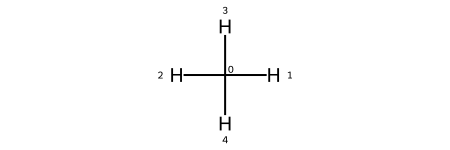

COMPND    me 
HETATM    1 C1 me      1       0.000  -0.000   0.000  1.00  0.00           C  
HETATM    2 H1 me      1      -0.644  -0.763  -0.432  1.00  0.00           H  
HETATM    3 H2 me      1      -0.391   0.985  -0.244  1.00  0.00           H  
HETATM    4 H3 me      1       0.030  -0.120   1.080  1.00  0.00           H  
HETATM    5 H4 me      1       1.004  -0.102  -0.404  1.00  0.00           H  
CONECT    1    2    3    4    5
END



In [3]:
mol = prep_mol_for_pdb('C', 'me ')
visualize.mol(mol)
display(Chem.Mol(mol, quickCopy=True))
print(Chem.MolToPDBBlock(mol))

In [43]:
# mol_2 = Chem.Mol(mol)
# conf = mol_2.GetConformer()
# for i, pos in enumerate(conf.GetPositions()):
#     conf.SetAtomPosition(i, np.array(pos) + 2.5)

# atom_counter = get_atom_counter(mol_2)
# for atom in mol_2.GetAtoms():
#     symbol = atom.GetSymbol()
#     counter = atom_counter[symbol]
#     atom_counter[symbol] += 1

#     info = Chem.AtomPDBResidueInfo()
#     info.SetName(f'{symbol}{counter}')
#     info.SetResidueName('me')
#     info.SetResidueNumber(2)
#     atom.SetPDBResidueInfo(info)

# mol = Chem.CombineMols(mol, mol_2)
# mol, _ = gfnxtb.opt(mol)
# visualize.mol(mol)

In [44]:
# mol, energy = orca_dft.opt(mol, orca_dir)
# visualize.mol(mol)
# print(energy)

## fitting

In [865]:
def scan_geom(mol, cons_type, cons_atoms, cons_min, step_size, threshold, orca_dir):
    results = {}
    min_mol, min_energy = orca_dft.opt_cons(mol, [cons_type], [cons_atoms], [cons_min], orca_dir)
    results[cons_min] = min_energy
    # forward
    cur_energy = min_energy
    cur_value = cons_min
    while cur_energy - min_energy < threshold:
        cur_value += step_size
        cur_mol, cur_energy = orca_dft.opt_cons(mol, [cons_type], [cons_atoms], [cur_value], orca_dir)
        results[cur_value] = cur_energy

    # backward
    cur_energy = min_energy
    cur_value = cons_min
    while cur_energy - min_energy < threshold:
        cur_value -= step_size
        cur_mol, cur_energy = orca_dft.opt_cons(mol, [cons_type], [cons_atoms], [cur_value], orca_dir)
        results[cur_value] = cur_energy

    return results

# scan_results = scan_geom(mol, 'bond', [0, 1], 1.091, 0.025, 8, orca_dir)
scan_results = scan_geom(mol, 'angle', [1, 0, 2], 109.5, 5, 8, orca_dir)

In [868]:
# r = [value/10 for value in scan_results.keys()]
theta = [np.radians(value) for value in scan_results.keys()]
E = [value * 4.184 for value in scan_results.values()]
min_energy = min(E)
E = [value - min_energy for value in E]

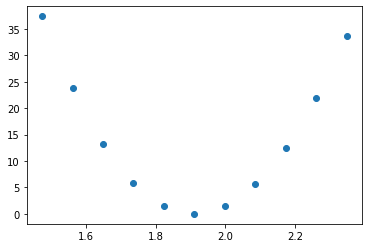

In [869]:
# plt.scatter(r, E)
plt.scatter(theta, E)
plt.show()

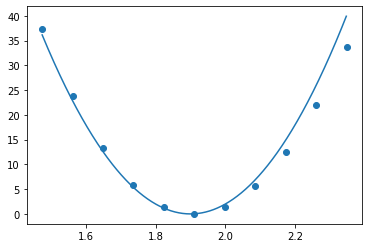

In [878]:
def harmonic(r, k1, k2, r0):
    return k1 * np.power((r - r0), 2) + k2 * np.power((r - r0), 3)

# x = np.arange(min(r), max(r), 0.001)
x = np.arange(min(theta), max(theta), 0.001)
# y = harmonic(x, 178000, -2500000, 0.1091)
y = harmonic(x, 200, 0, 1.9)

plt.plot(x, y)
# plt.scatter(r, E)
plt.scatter(theta, E)
plt.show()

In [880]:
def opt_harmonic(x, r, E):
    E_pred = [harmonic(value, x[0], x[1], x[2]) for value in r]
    return mean_squared_error(E, E_pred)

res = minimize(
    # lambda x: opt_harmonic(x, r, E),
    lambda x: opt_harmonic(x, theta, E),
    # [178000, -2500000, 0.1091],
    [200, 0, 1.9],
    method='Nelder-Mead'
)

res

 final_simplex: (array([[187.1149347 , -22.84748409,   1.91067358],
       [187.11492517, -22.84739312,   1.9106736 ],
       [187.11494545, -22.84755187,   1.91067354],
       [187.11492701, -22.84757935,   1.91067355]]), array([0.00123666, 0.00123666, 0.00123666, 0.00123666]))
           fun: 0.0012366613549262247
       message: 'Optimization terminated successfully.'
          nfev: 341
           nit: 193
        status: 0
       success: True
             x: array([187.1149347 , -22.84748409,   1.91067358])

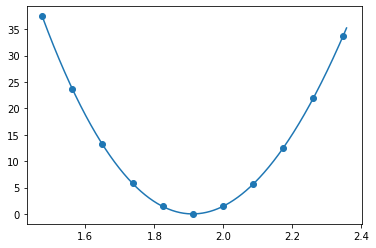

In [882]:
# x = np.arange(min(r), max(r)+0.01, 0.001)
x = np.arange(min(theta), max(theta)+0.01, 0.001)
y = harmonic(x, res.x[0], res.x[1], res.x[2])

plt.plot(x, y)
# plt.scatter(r, E)
plt.scatter(theta, E)
plt.show()

In [48]:
print(Chem.MolToPDBBlock(mol))

COMPND    me
HETATM    1 C1 me     1       0.000  -0.000   0.000  1.00  0.00           C  
HETATM    2 H1 me     1      -0.635  -0.829  -0.320  1.00  0.00           H  
HETATM    3 H2 me     1      -0.419   0.940  -0.364  1.00  0.00           H  
HETATM    4 H3 me     1       0.049   0.022   1.091  1.00  0.00           H  
HETATM    5 H4 me     1       1.005  -0.133  -0.407  1.00  0.00           H  
CONECT    1    2    3    4    5
END



## simulation

In [4]:
df_atoms = pd.DataFrame(columns=['symbol', 'r1_neighbors', 'r2_neighbors', 'r3_neighbors', 'name', 'class', 'mass'])
df_atoms.loc[len(df_atoms.index)] = ['H', None, None, None, 'H', 'H', 1.007947]
df_atoms.loc[len(df_atoms.index)] = ['H', ['C'], None, None, 'H1', 'H', 1.007947]
df_atoms.loc[len(df_atoms.index)] = ['C', None, None, None, 'C', 'C', 12.01078]
df_atoms.loc[len(df_atoms.index)] = ['C', ['H', 'H', 'H', 'H'], None, None, 'C1', 'C', 12.01078]

df_atoms

,symbol,r1_neighbors,r2_neighbors,r3_neighbors,name,class,mass
0,H,None,None,None,H,H,1.007947
1,H,[C],None,None,H1,H,1.007947
2,C,None,None,None,C,C,12.010780
3,C,"[H, H, H, H]",None,None,C1,C,12.010780


In [5]:
df_bonds = pd.DataFrame(columns=['atoms', 'k1', 'k2', 'r0'])
df_bonds.loc[len(df_bonds.index)] = [['C1', 'H1'], 166942.855, -3014996.02, 0.109260467]

df_bonds

,atoms,k1,k2,r0
0,"[C1, H1]",166942.855,-3014996.02,0.10926


In [6]:
df_angles = pd.DataFrame(columns=['atoms', 'k1', 'k2', 'theta0'])
df_angles.loc[len(df_angles.index)] = [['H1', 'C1', 'H1'], 187.1149, -22.84748409, 1.910673]

df_angles

,atoms,k1,k2,theta0
0,"[H1, C1, H1]",187.1149,-22.847484,1.910673


In [8]:
simulation = get_simulation(mol, df_atoms, df_bonds, df_angles)
openmm_sp(simulation)

0.1855686753988266

In [9]:
minimize_openmm(simulation)

(<openmm.app.simulation.Simulation at 0x1039dd7e0>, 4.275319224689156e-05)

In [10]:
positions = simulation.context.getState(getPositions=True).getPositions()
app.PDBFile.writeFile(simulation.topology, positions, open('tmp.pdb', 'w'))

In [400]:
simulation.reporters.append(app.PDBReporter('tmp.pdb', 1))
simulation.step(100)